In [14]:
from sympy import *
import numpy as np
import pandas as pd

from direct_lingam.simulate_data import get_Lambda, simulate_data
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)
import multiprocess as mp

from models import CM

Lambda is 
 [[0 0 0]
 [0 0 0]
 [0 1 0]]
Gamma is 
 [[1 1]
 [1 1]
 [1 1]]


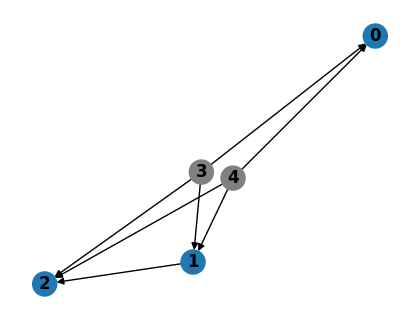

In [15]:
Lambda = get_Lambda([(2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1, 1], [1, 1], [1, 1]])
print(f"Gamma is \n {Gamma}")
highest_l = 2
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [16]:
np.hstack((Lambda, Gamma))

array([[0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 1]])

In [17]:
def run_experiment(seed):
    # run the experiment using the given parameters
    # Set the random seed
    noise_distribution = 'gamma'
    samples_sizes = [10**n for n in range(1, 8)]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]
    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]

    # Perform the experiment
    causal_effect_estimate = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        model = CM(X_sample, highest_l=highest_l)
        causal_effect_estimate.append(model.estimate_effect())

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Effect Estimate': causal_effect_estimate,
    })
    return seed_df


def parallel_simulation(reps):
    pool = mp.Pool(mp.cpu_count())
    seeds = range(reps)
    results = pool.map(run_experiment, seeds)

    pool.close()
    return pd.concat(results, ignore_index=True)

results_df = parallel_simulation(20)

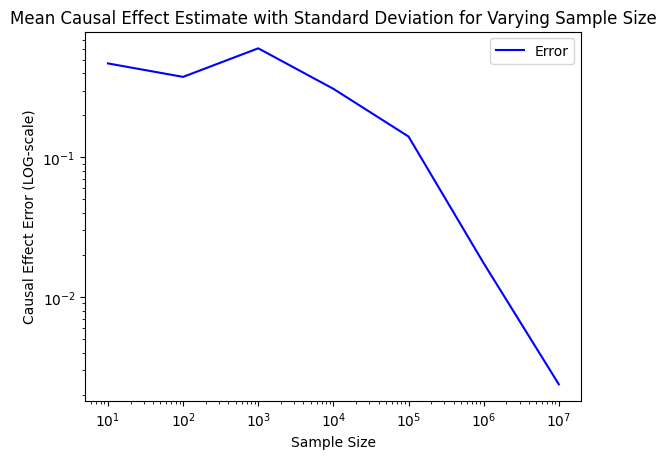

In [21]:
import matplotlib.pyplot as plt

results_df["Error"] = np.abs((results_df['Effect Estimate'] - results_df["True Effect"]))
                            #  /results_df["True Effect"])  # Calculate the error


# Group the results by sample size and calculate the mean
mean_results = results_df.groupby('Sample Size').median()
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(mean_results.index, mean_results["Error"],
         label='Error',
         color = "blue")



plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Mean Causal Effect Estimate with Standard Deviation for Varying Sample Size')
plt.show()